In [122]:
# !pip install numpy scipy matplotlib wave

import numpy as np
from scipy.ndimage import gaussian_filter1d
import scipy.signal as signal
import matplotlib.pyplot as plt
import Organ.readwav as readwav
from IPython.display import Audio

In [193]:
rate, array = readwav.readwav("./Organ/note_20.wav")
print("rate: ", rate)
print("array: ", array)

array = array.mean(axis=1)

# Seleziona solo una finestra stabile (es. dal 0.5s al 1s)
start = int(0.5 * rate)
end = int(4.0 * rate)
segment = array[start:end]

rate:  48000
array:  [[     0      0]
 [     0      0]
 [     0      0]
 ...
 [264151 282872]
 [267160 280098]
 [269755 279478]]


In [194]:
# Applica una finestra Hann
window = signal.hann(len(segment))
windowed = segment * window

In [195]:
# FFT
N = len(windowed)
T = 1.0 / rate
yf = np.fft.fft(windowed)
xf = np.fft.fftfreq(N, T)

In [196]:
# Spettro di potenza (solo parte positiva)
power = np.abs(yf[:N//2])**2
freqs = xf[:N//2]

In [197]:
# play the sound
Audio(array
       * signal.windows.taylor(len(array))
         ,rate=rate)

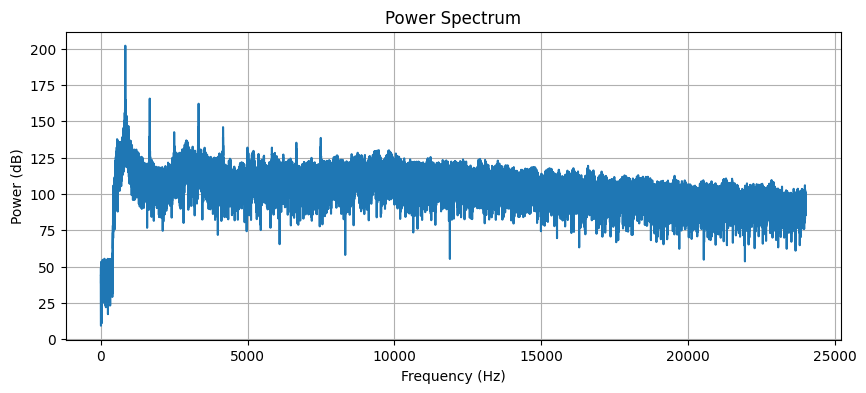

In [198]:
# Plot
plt.figure(figsize=(10, 4))
plt.plot(freqs, 10 * np.log10(power))
plt.title("Power Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.grid()
plt.show()

In [199]:
prominence = 20
peaks = np.array([], dtype = np.int64)
while(len(peaks)<4) :
    
    # Trova picchi con prominence adattiva
    peaks, _ = signal.find_peaks(np.log(power), prominence = prominence)
    
    prominence -= 1

# Frequenze dei picchi
peak_freqs = freqs[peaks]

print("Frequenze principali:", peak_freqs)


Frequenze principali: [ 832.28571429 1664.57142857 3329.14285714 4161.42857143]


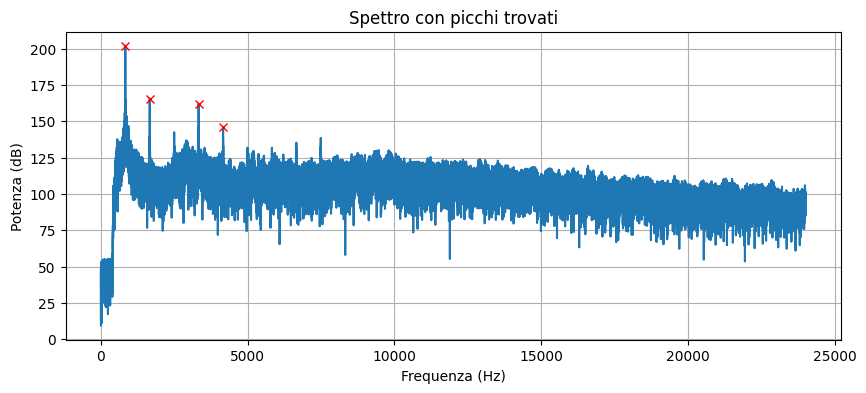

In [200]:
plt.figure(figsize=(10, 4))
plt.plot(freqs, 10 * np.log10(power))
plt.plot(freqs[peaks], 10 * np.log10(power[peaks]), "rx")  # i picchi
plt.title("Spettro con picchi trovati")
plt.xlabel("Frequenza (Hz)")
plt.ylabel("Potenza (dB)")
plt.grid()
plt.show()

In [201]:

# Differenze tra frequenze dei picchi
#df = np.diff(peak_freqs)

# Approx. GCD
def approx_gcd(arr, tol=0.1):
    arr_int = (arr / tol).astype(int)
    result = arr_int[0]
    for val in arr_int[1:]:
        result = np.gcd(result, val)
    return result * tol

f0_gcd = approx_gcd(peak_freqs)
print(f"Frequenza fondamentale stimata (GCD): {f0_gcd} Hz")

print(np.diff(np.sort(peak_freqs)))

Frequenza fondamentale stimata (GCD): 0.1 Hz
[ 832.28571429 1664.57142857  832.28571429]


In [202]:
frequenze_organo = 440 * 2 ** ((np.arange(-57, 51)) / 12)

def stima_fondamentale_gcd_robusto(peak_freqs, f_min=20., f_max=4000., tol=0.1):
    #diffs = np.diff(np.sort(peak_freqs))
    gcd_scores = {}

    for f0_cand in frequenze_organo:
        
        count = sum(
            np.abs((d % f0_cand)) < tol*f0_cand or np.abs(f0_cand - (d % f0_cand)) < tol*f0_cand
            for d in peak_freqs
        )
        gcd_scores[f0_cand] = count

    # Trova la frequenza con il punteggio massimo
    max_score = max(gcd_scores.values())  # Trova il punteggio massimo
    best_f0 = max(f for f, score in gcd_scores.items() if score == max_score)
    
    return best_f0, max_score, gcd_scores

best_f, max_score, scores = stima_fondamentale_gcd_robusto(peak_freqs)

print(f"Frequenza fondamentale stimata (GCD): {best_f} Hz")

print(scores)
print(max_score)


Frequenza fondamentale stimata (GCD): 830.6093951598903 Hz
{16.351597831287414: 0, 17.323914436054505: 2, 18.354047994837977: 0, 19.445436482630058: 1, 20.601722307054366: 1, 21.826764464562746: 0, 23.12465141947715: 4, 24.499714748859326: 2, 25.956543598746574: 1, 27.5: 1, 29.13523509488062: 0, 30.86770632850775: 2, 32.70319566257483: 0, 34.64782887210901: 3, 36.70809598967594: 0, 38.890872965260115: 1, 41.20344461410875: 1, 43.653528929125486: 1, 46.2493028389543: 4, 48.999429497718666: 4, 51.91308719749314: 2, 55.0: 0, 58.27047018976124: 0, 61.7354126570155: 2, 65.40639132514966: 0, 69.29565774421802: 4, 73.41619197935188: 0, 77.78174593052023: 0, 82.4068892282175: 1, 87.30705785825097: 1, 92.4986056779086: 4, 97.99885899543733: 2, 103.82617439498628: 4, 110.0: 0, 116.54094037952248: 0, 123.47082531403103: 1, 130.8127826502993: 0, 138.59131548843604: 4, 146.8323839587038: 0, 155.56349186104046: 0, 164.81377845643496: 2, 174.61411571650194: 1, 184.9972113558172: 2, 195.99771799087463

In [192]:
duration = 5
t = np.linspace(0, duration, int(rate * duration), endpoint=False)
sound = 10 * np.sin(2 * np.pi * best_f * t)
Audio(sound
         ,rate=rate)

Frequenza fondamentale è :  91.95402298850574 Hz
